In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from Supporting_func import load_dataset, random_mini_batches, convert_to_one_hot, predict

%matplotlib inline
np.random.seed(1)

# 1 - Building neural network in tensorflow

### 1.0 -SIGNS Dataset

One afternoon, with some friends we decided to teach our computers to decipher sign language. We spent a few hours taking pictures in front of a white wall and came up with the following dataset. It's now your job to build an algorithm that would facilitate communications from a speech-impaired person to someone who doesn't understand sign language.

- **Training set**: 1080 pictures (64 by 64 pixels) of signs representing numbers from 0 to 5 (180 pictures per number).
- **Test set**: 120 pictures (64 by 64 pixels) of signs representing numbers from 0 to 5 (20 pictures per number).

Note that this is a subset of the SIGNS dataset. The complete dataset contains many more signs.

Here are examples for each number, and how an explanation of how we represent the labels. These are the original pictures, before we lowered the image resolutoion to 64 by 64 pixels.
<img src="images/hands.png" style="width:800px;height:350px;"><caption><center> <u><font color='purple'> **Figure 1**</u><font color='purple'>: SIGNS dataset <br> <font color='black'> </center>


Run the following code to load the dataset.

In [16]:
# Loading the dataset
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

Change the index below and run the cell to visualize some examples in the dataset.

y = 5


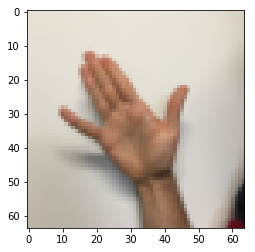

In [17]:
# Example of a picture
index = 120
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

As usual we flatten the image dataset, then normalize it by dividing by 255. On top of that, we will convert each label to a one-hot vector as shown in Figure 1.

In [18]:
# Flatten the training and test images
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T

# Normalize image vectors
X_train = X_train_flatten/255.
X_test = X_test_flatten/255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6)
Y_test = convert_to_one_hot(Y_test_orig, 6)

print ("number of training examples = " + str(X_train.shape[1]))
print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (12288, 1080)
Y_train shape: (6, 1080)
X_test shape: (12288, 120)
Y_test shape: (6, 120)


**Note** that 12288 comes from $64 \times 64 \times 3$. Each image is square, 64 by 64 pixels, and 3 is for the RGB colors. Please make sure all these shapes make sense to you before continuing.

**The goal** is to build an algorithm capable of recognizing a sign with high accuracy. To do so, we are going to build a tensorflow model.

**The model** is *LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX*. The SIGMOID output layer has been converted to a SOFTMAX. A SOFTMAX layer generalizes SIGMOID to when there are more than two classes. 

### 2.1 - Create placeholders

First task is to create placeholders for `X` and `Y`. This will allow us to later pass our training data in when we run our session. 

In [19]:
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of an image vector (num_px * num_px = 64 * 64 * 3 = 12288)
    n_y -- scalar, number of classes (from 0 to 5, so -> 6)
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
    
    Tips:
    - You will use None because it let's us be flexible on the number of examples you will for the placeholders.
      In fact, the number of examples during test/train is different.
    """

    X = tf.placeholder(tf.float32,shape=(n_x,None),name='X')
    Y = tf.placeholder(tf.float32,shape=(n_y,None),name='Y')
    
    
    return X, Y

### 2.2 - Initializing the parameters

The second task is to initialize the parameters in tensorflow.

- We are going use Xavier Initialization for weights
- Zero Initialization for biases. The shapes are given below. 

In [21]:
def initialize_parameters():
    """
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [25, 12288]
                        b1 : [25, 1]
                        W2 : [12, 25]
                        b2 : [12, 1]
                        W3 : [6, 12]
                        b3 : [6, 1]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    
    tf.set_random_seed(1)                   # so that your "random" numbers match ours
        
 
    W1 = tf.get_variable('W1',shape=[25,12288],initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b1 = tf.get_variable('b1',shape=[25,1],initializer=tf.zeros_initializer())
    W2 = tf.get_variable('W2',shape=[12,25],initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b2 = tf.get_variable('b2',shape=[12,1],initializer=tf.zeros_initializer())
    W3 = tf.get_variable('W3',shape=[6,12],initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b3 = tf.get_variable('b3',shape=[6,1],initializer=tf.zeros_initializer())
  

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

As expected, the parameters haven't been evaluated yet.

### 2.3 - Forward propagation in tensorflow 

The function will take in a dictionary of parameters and it will complete the forward pass. The functions we will be using are: 

- `tf.add(...,...)` to do an addition
- `tf.matmul(...,...)` to do a matrix multiplication
- `tf.nn.relu(...)` to apply the ReLU activation

In [23]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
                                                                      # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1,X),b1)                                   # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                               # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2,A1),b2)                                  # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                               # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3,A2),b3)                                  # Z3 = np.dot(W3,Z2) + b3
    
    
    return Z3

You may have noticed that the forward propagation doesn't output any cache. You will understand why below, when we get to brackpropagation.

### 2.4 Compute cost

It is very easy to compute the cost using:
```python
tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = ..., labels = ...))
```
- It is important to know that the "`logits`" and "`labels`" inputs of `tf.nn.softmax_cross_entropy_with_logits` are expected to be of shape (number of examples, num_classes). We have thus transposed Z3 and Y for you.
- Besides, `tf.reduce_mean` basically does the summation over the examples.

In [25]:
def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=labels))
    
    return cost

### 2.5 - Backward propagation & parameter updates

- This is where we become grateful to programming frameworks. All the backpropagation and the parameters update is taken care of in 1 line of code. It is very easy to incorporate this line in the model.

- After we compute the cost function. we will create an "`optimizer`" object. we have to call this object along with the cost when running the tf.session. When called, it will perform an optimization on the given cost with the chosen method and learning rate.

This computes the backpropagation by passing through the tensorflow graph in the reverse order. From cost to inputs.

**Note** When coding, we often use `_` as a "throwaway" variable to store values that we won't need to use later. Here, `_` takes on the evaluated value of `optimizer`, which we don't need (and `c` takes the value of the `cost` variable). 

### 2.6 - Building the model

Now, we will bring it all together! 

In [29]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
  
    X, Y = create_placeholders(n_x,n_y)
    
    # Initialize parameters
    
    parameters = initialize_parameters()
   
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    
    Z3 = forward_propagation(X,parameters)
   
    
    # Cost function: Add cost function to tensorflow graph
   
    cost = compute_cost(Z3,Y)
    
    '''
    regularizer = 0
    #I did regularization to both weight(Wi) and biases (bi), no need to regularize biases(bi)
    for i in parameters.values():
        regularizer += tf.nn.l2_loss(i)
    
    cost = tf.reduce_mean(cost + 0.02 * regularizer)
    '''
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
   
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                           # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
               
                _ , minibatch_cost = sess.run([optimizer,cost],feed_dict={X:minibatch_X,Y:minibatch_Y})
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

- Run the following cell to train your model!

Cost after epoch 0: 2.725407
Cost after epoch 100: 1.473156
Cost after epoch 200: 1.258005
Cost after epoch 300: 1.138237
Cost after epoch 400: 1.025631
Cost after epoch 500: 0.950217
Cost after epoch 600: 0.934119
Cost after epoch 700: 0.864225
Cost after epoch 800: 0.810476
Cost after epoch 900: 0.778588
Cost after epoch 1000: 0.750915
Cost after epoch 1100: 0.722322
Cost after epoch 1200: 0.695573
Cost after epoch 1300: 0.676875
Cost after epoch 1400: 0.678846


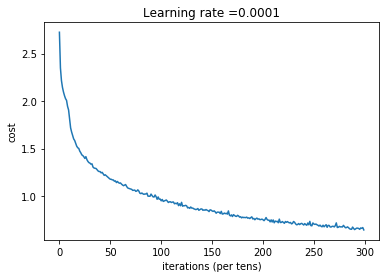

Parameters have been trained!
Train Accuracy: 0.948148
Test Accuracy: 0.766667


In [30]:
parameters = model(X_train, Y_train, X_test, Y_test)

Amazing, our algorithm can recognize a sign representing a figure between 0 and 5 with 76.67% accuracy.

**Insights**:
- our model seems big enough to fit the training set well. However, given the difference between train and test accuracy, you could try to add L2 or dropout regularization to reduce overfitting. 
- Think about the session as a block of code to train the model. Each time you run the session on a minibatch, it trains the parameters. In total you have run the session a large number of times (1500 epochs) until you obtained well trained parameters.

### 2.7 - Test with your own image 
To do that:
    1. Click on "File" in the upper bar of this notebook, then click "Open" to go on your Coursera Hub.
    2. Add your image to this Jupyter Notebook's directory, in the "images" folder
    3. Write your image's name in the following code
    4. Run the code and check if the algorithm is right!

In [ ]:
import scipy
from PIL import Image
from scipy import ndimage

my_image = "thumbs_up.jpg"

# We preprocess your image to fit your algorithm.
fname = "images/" + my_image
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(64,64)).reshape((1, 64*64*3)).T
my_image_prediction = predict(my_image, parameters)

plt.imshow(image)
print("Your algorithm predicts: y = " + str(np.squeeze(my_image_prediction)))


**What you should remember**:
- Tensorflow is a programming framework used in deep learning
- The two main object classes in tensorflow are Tensors and Operators. 
- When you code in tensorflow you have to take the following steps:
    - Create a graph containing Tensors (Variables, Placeholders ...) and Operations (tf.matmul, tf.add, ...)
    - Create a session
    - Initialize the session
    - Run the session to execute the graph
- You can execute the graph multiple times as you've seen in model()
- The backpropagation and optimization is automatically done when running the session on the "optimizer" object.